In [14]:
from dotenv import load_dotenv
from langchain_core.documents import Document
from langchain_community.vectorstores import Qdrant
from langchain.text_splitter import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import yagmail
import os
import imaplib
import email
from email.header import decode_header
import re

load_dotenv()

def load_txt_as_documents(txt_file):
    with open(txt_file, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text

raw_text = load_txt_as_documents(r"C:\Users\FINE LAPTOP\Desktop\Langchain\langgraph\rag_service.txt")
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_text(raw_text)
documents = [Document(page_content=chunk) for chunk in texts]


embedding_function = OpenAIEmbeddings()

qdrant_client = QdrantClient(host="localhost", port=6333)
qdrant_client.recreate_collection(
    collection_name="rag_txt_collection",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)


db = Qdrant(
    client=qdrant_client,
    collection_name="rag_txt_collection",
    embeddings=embedding_function
)
db.add_documents(documents)
print("Uploaded documents to running Docker Qdrant.")

class GraphState(TypedDict):
    question: str
    context: str
    answer: str
    recipient: str
    inbox_subject: str

def read_inbox(state: GraphState) -> GraphState:
    EMAIL = os.getenv("EMAIL_USER")
    PASSWORD = os.getenv("EMAIL_PASSWORD")

    try:
        imap = imaplib.IMAP4_SSL("imap.gmail.com")
        imap.login(EMAIL, PASSWORD)
        imap.select("inbox")

        status, messages = imap.search(None, 'UNSEEN')
        mail_ids = messages[0].split()

        if not mail_ids:
            raise Exception("No unread emails found.")

        latest_email_id = mail_ids[-1]
        status, msg_data = imap.fetch(latest_email_id, "(RFC822)")

        for response_part in msg_data:
            if isinstance(response_part, tuple):
                msg = email.message_from_bytes(response_part[1])

              
                subject, encoding = decode_header(msg["Subject"])[0]
                if isinstance(subject, bytes):
                    subject = subject.decode(encoding or "utf-8")

               
                from_, encoding = decode_header(msg.get("From"))[0]
                if isinstance(from_, bytes):
                    from_ = from_.decode(encoding or "utf-8")

                match = re.search(r'<(.+?)>', from_)
                sender_email = match.group(1) if match else from_

                body = ""
                if msg.is_multipart():
                    for part in msg.walk():
                        if part.get_content_type() == "text/plain":
                            body = part.get_payload(decode=True).decode(errors="ignore")
                            break
                else:
                    body = msg.get_payload(decode=True).decode(errors="ignore")

                return {
                    "question": body.strip(),
                    "recipient": sender_email,
                    "inbox_subject": subject,
                    "context": "",
                    "answer": ""
                }

    except Exception as e:
        print(f"Failed to read inbox: {e}")
        return state

def send_email(state: GraphState):
    recipient = state.get("recipient")
    subject = f"RE: {state['inbox_subject']}"
    body = state["answer"]

    try:
        yag = yagmail.SMTP(user=os.getenv("EMAIL_USER"), password=os.getenv("EMAIL_PASSWORD"))
        yag.send(to=recipient, subject=subject, contents=body)
        print(f"Email sent to {recipient}")
    except Exception as e:
        print(f"Failed to send email: {e}")
    
    return state 

llm = ChatOpenAI(model="gpt-3.5-turbo")

def retrieve(state: GraphState):
    query = state["question"]
    retriever = db.as_retriever()
    docs = retriever.invoke(query)
    context = "\n\n".join([doc.page_content for doc in docs])
    return {
        "question": query,
        "context": context,
        "recipient": state["recipient"],
        "inbox_subject": state["inbox_subject"],
        "answer": ""
    }

def generate(state: GraphState):
    prompt = f"""
You are a helpful customer support assistant.

You received the following question via email:
---
Subject: {state['inbox_subject']}
Message: {state['question']}
---

Use the context below to craft a professional, detailed, and helpful reply to this email. The answer should:
- Clearly acknowledge the user's concern.
- Provide step-by-step instructions or a clear explanation.
- Maintain a friendly and supportive tone.
- End with an invitation to reach out for further help.

Context:
{state['context']}

Respond directly to the user below:
"""

    response = llm.invoke(prompt)

    return {
        "question": state["question"],
        "context": state["context"],
        "answer": response.content,
        "recipient": state["recipient"],
        "inbox_subject": state["inbox_subject"]
    }


graph = StateGraph(GraphState)
graph.add_node("read_inbox", RunnableLambda(read_inbox))
graph.add_node("retrieve", RunnableLambda(retrieve))
graph.add_node("generate", RunnableLambda(generate))
graph.add_node("send_email", RunnableLambda(send_email))

graph.set_entry_point("read_inbox")
graph.add_edge("read_inbox", "retrieve")
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", "send_email")
graph.add_edge("send_email", END)

app = graph.compile()

result = app.invoke({})

print("Final Answer:", result["answer"])


Uploaded documents to running Docker Qdrant.
Email sent to shahzain0066@gmail.com
Final Answer: Thank you for reaching out with your concern about setting up a new delivery address. I understand the importance of getting this right, and I'm here to help. To proceed, please follow these steps:

1. Log in to your account on our website.
2. Go to the "My Account" or "Profile" section.
3. Look for the option to manage your "Shipping Addresses" or similar.
4. Click on "Add a New Address" or "Edit Shipping Addresses".
5. Enter the details of your new delivery address, including the recipient's name, street address, city, state, ZIP code, and any other necessary information.
6. Review the information for accuracy and save the changes.

If you encounter any difficulties or need further assistance along the way, please do not hesitate to reach out. I'm here to support you through this process.


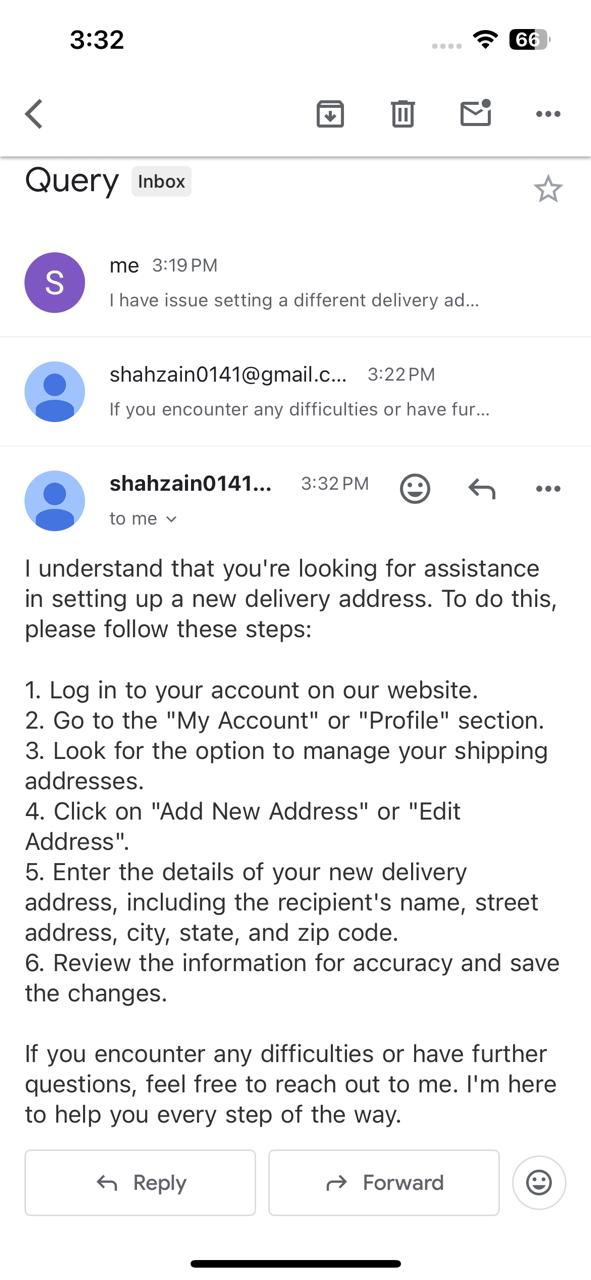

In [15]:

from PIL import Image
from IPython.display import display


img_path = "WhatsApp Image 2025-07-25 at 3.33.05 PM.jpeg"
image = Image.open(img_path)
display(image)
